In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras import regularizers
import random
from keras.utils.vis_utils import plot_model
import time
from IPython.display import Image


# The goal

<img src="https://dl.dropboxusercontent.com/s/vxo84ex382z9hwz/project_ANN.png?dl=0" width="800">


## Load the dataset

In [2]:
labels = pd.read_csv('data/X_models.csv')
spectra = np.loadtxt("data/y_RVS.csv", delimiter=',')
spectra = spectra[:,1:spectra.shape[1]-1]


# Inspect the dataset

In [3]:
labels.head()

,runID,teff,logg,feH,vmic,vbroad,sife,cafe,tife,mgfe,ndfe,sfe,zrfe,nfe,crfe,cefe,nife
0,1000000000000000000,6218.0,4.619077,-0.910052,2.605483,8.816360,0.418184,0.459938,0.119170,0.434419,0.480405,-0.123946,0.191479,0.398063,-0.324044,-0.292349,0.266274
1,1000000000000000001,6254.0,4.664552,-0.289723,0.610352,18.323620,-0.141154,-0.044178,0.394487,0.067355,0.060857,-0.052785,0.060776,-0.213662,-0.479466,0.399770,-0.105692
2,1000000000000000002,5005.0,3.627608,0.576484,0.913904,28.404045,0.360096,0.126649,-0.296405,0.330141,0.446568,0.149643,-0.229689,0.090391,-0.457319,-0.084583,0.402419
3,1000000000000000003,3245.0,0.438310,-1.283513,2.452431,24.500015,0.210533,-0.069649,-0.401775,-0.162500,-0.300793,-0.254474,-0.277514,0.261310,-0.091852,0.264879,0.023607
4,1000000000000000004,4282.0,0.718020,-0.749160,2.511468,18.305674,-0.152219,-0.257944,-0.277805,-0.229354,-0.449344,-0.251708,-0.331349,0.495421,0.128342,-0.354881,-0.475055


In [4]:
print("Sample size: {}".format(len(labels)))
print("Spectra matrix shape: {}".format(spectra.shape))


Sample size: 5000
Spectra matrix shape: (5000, 2398)


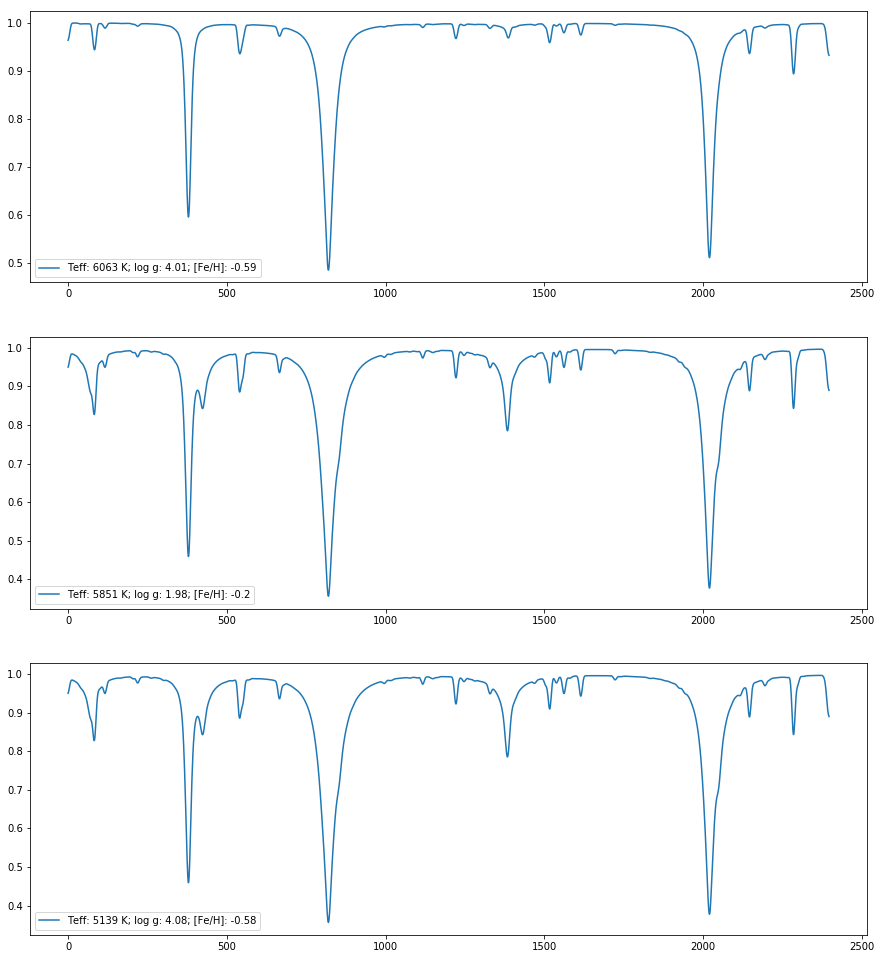

In [7]:
s = np.random.randint(low=0, high=len(labels), size=3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,17))
ax[0].plot(spectra[s[0]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[0]]), np.round(labels.logg[s[0]],2), np.round(labels.feH[s[0]],2)))
ax[1].plot(spectra[s[1]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[1]]), np.round(labels.logg[s[1]],2), np.round(labels.feH[s[1]],2)))
ax[2].plot(spectra[s[1]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[2]]), np.round(labels.logg[s[2]],2), np.round(labels.feH[s[2]],2)))
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


## Train/Test samples splitting

In [8]:
spectra[np.isinf(spectra)]

array([], dtype=float64)

In [9]:
columns = ['teff', 'logg', 'feH', 'vmic', 'vbroad', 'sife', 'cafe', 'tife',
       'mgfe', 'ndfe', 'sfe', 'zrfe', 'nfe', 'crfe', 'cefe', 'nife']
X = labels[columns]

id_train, id_test, X_train, X_test, y_train, y_test = train_test_split(np.array(labels['runID']), X, spectra, test_size=0.2, random_state=42, shuffle=True)

print("Size training sample: {}".format(len(X_train)))
print("Size test sample: {}".format(len(X_test)))

Size training sample: 4000
Size test sample: 1000


## Standardization

<img src="https://dl.dropboxusercontent.com/s/r27eolyxrnojvbe/standardization.png?dl=0" width="600">



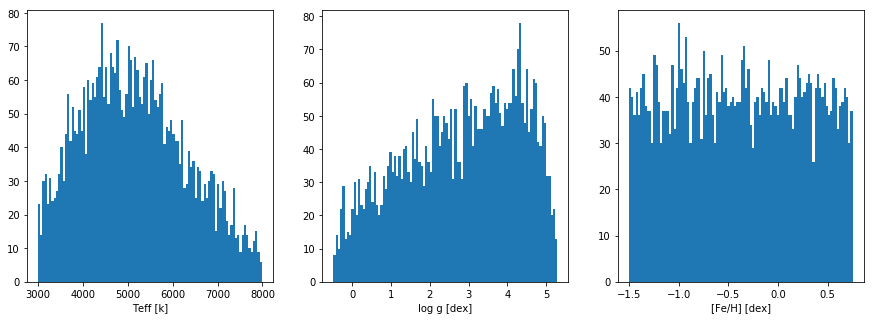

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
a = plt.hist(X_train.teff, bins=100)
plt.xlabel('Teff [k]')
plt.subplot(132)
a = plt.hist(X_train.logg, bins=100)
plt.xlabel('log g [dex]')
plt.subplot(133)
a = plt.hist(X_train.feH, bins=100)
plt.xlabel('[Fe/H] [dex]')
plt.show()




In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_std_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_std_test = scaler.transform(X_test)


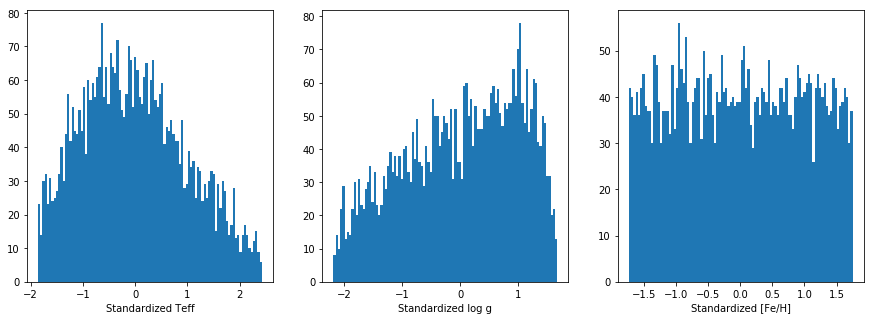

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
a = plt.hist(X_std_train.T[0], bins=100)
plt.xlabel('Standardized Teff')
plt.subplot(132)
a = plt.hist(X_std_train.T[1], bins=100)
plt.xlabel('Standardized log g')
plt.subplot(133)
a = plt.hist(X_std_train.T[2], bins=100)
plt.xlabel('Standardized [Fe/H]')
plt.show()


## Define the ANN

### The input layer
The input vector needs one input neuron per feature. For tabular data, this is the number of relevant features in your dataset. You want to carefully select these features and remove any that may contain patterns that won't generalize beyond the training set (and cause overfitting).

In [15]:
# The neurons of the input layer = input features
print("Number of input features: {}".format(X_std_train.shape[1]))

shape_X = X_std_train.shape[1]

#  input
input_layer = keras.layers.Input(shape=[shape_X])

print(shape_X)

Number of input features: 16
16


##### ### The hidden layers

We try with 5 hidden layers of 100 neurons each.
The layers are **dense** (of fully connected), which means that all the neurons of a layer are connected to all the neurons of the previous and following layer.


In [16]:
# layer 1
L1 = keras.layers.Dense(100)(input_layer)
L1a = tf.keras.layers.ReLU()(L1)

# layer 2
L2 = keras.layers.Dense(100)(L1a)
L2a = tf.keras.layers.ReLU()(L2)

# layer 3
L3 = keras.layers.Dense(100)(L2a)
L3a = tf.keras.layers.ReLU()(L3)

# layer 4
L4 = keras.layers.Dense(100)(L3a)
L4a = tf.keras.layers.ReLU()(L4)

# layer 5
L5 = keras.layers.Dense(100)(L4a)
L5a = tf.keras.layers.ReLU()(L5)

# other layers?



### The output layer

This is the number of predictions you want to make.

- **Regression**: For regression tasks, this can be one value (e.g. housing price). For multi-variate regression, it is one neuron per predicted value (e.g. for bounding boxes it can be 4 neurons – one each for bounding box height, width, x-coordinate, y-coordinate).

- **Classification**: For binary classification (spam-not spam), we use one output neuron per positive class, wherein the output represents the probability of the positive class. For multi-class classification (e.g. in object detection where an instance can be classified as a car, a dog, a house etc.), we have one output neuron per class, and use the softmax activation function on the output layer to ensure the final probabilities sum to 1.

In [18]:
# The neurons of the input layer = number of pixels of each spectrum
print("Number of pixels: {}".format(y_train.shape[1]))


shape_y = y_train.shape[1]

#  output
output = keras.layers.Dense(shape_y)(L5a)


Number of pixels: 2398


### Wrap it together

In [20]:
model = keras.models.Model(inputs=[input_layer], outputs=[output])

print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1700      
_________________________________________________________________
re_lu (ReLU)                 (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 100)              

### Compile the model

- **Loss function**

<a href="https://keras.io/api/losses/">Loss functions from Keras</a>


In [22]:
loss = tf.keras.losses.MeanSquaredError()
loss = tf.keras.losses.MeanAbsoluteError()
#loss = keras.losses.MeanAbsolutePercentageError()


- **Optimizer**. Gradient Descent and Stochastic Gradient Descent aren't the only optimizers in town! There's a few different ones to choose from.

In [23]:
#optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #momentum optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.002, epsilon=1e-07, beta_1=0.9, beta_2=0.999) #adam


In [25]:
model.compile(loss=[loss], optimizer=optimizer)


### Train the ANN

- **batch_size**

- **epochs**

In [26]:
model.fit(X_std_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_std_test, y_test))


Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.1472 - val_loss: 0.0697
Epoch 2/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0546 - val_loss: 0.0401
Epoch 3/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.0227
Epoch 4/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 5/100
125/125 [==============================] - 1s 4ms/step - loss: 0.0158 - val_loss: 0.0154
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0144
Epoch 8/100
125/125 [==============================] - 1s 4ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 9/100
125/125 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 10/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0106 - val_lo

125/125 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 82/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 83/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 84/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 85/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 86/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 87/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 88/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 89/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 90/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 

## Learning curve

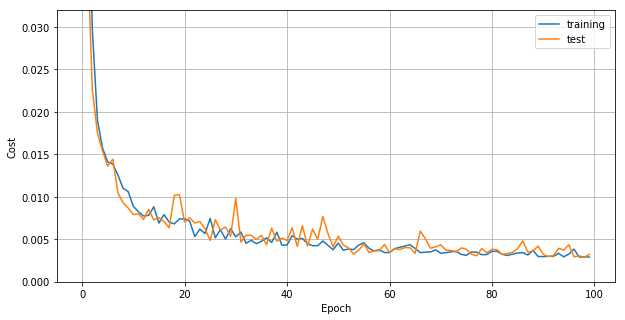

In [29]:
m1_tr_cost = model.history.history['loss']
m1_val_cost = model.history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(m1_tr_cost, label='training')
ax.plot(m1_val_cost, label='test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
#ax.set_xlim([0,100])
ax.set_ylim([0,0.032])
ax.legend()
ax.grid()
plt.show()

Note that if I run **fit** again, it continues the training from where it has left.

In [30]:
model.fit(X_std_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_std_test, y_test))


Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 3/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 4/10
125/125 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/10
125/125 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 6/10
125/125 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/10
125/125 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/10
125/125 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 9/10
125/125 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0031 - val_loss: 0.0036

If I want to restart the training, I need to **compile** again.

In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.002, epsilon=1e-07, beta_1=0.9, beta_2=0.999) #adam
#model = keras.models.Model(inputs=[input_layer], outputs=[output])
#model.compile(loss=[loss], optimizer=optimizer)
#model.fit(X_std_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_std_test, y_test))


## Inspect the results

Processing time: 0.05222320800021407 seconds


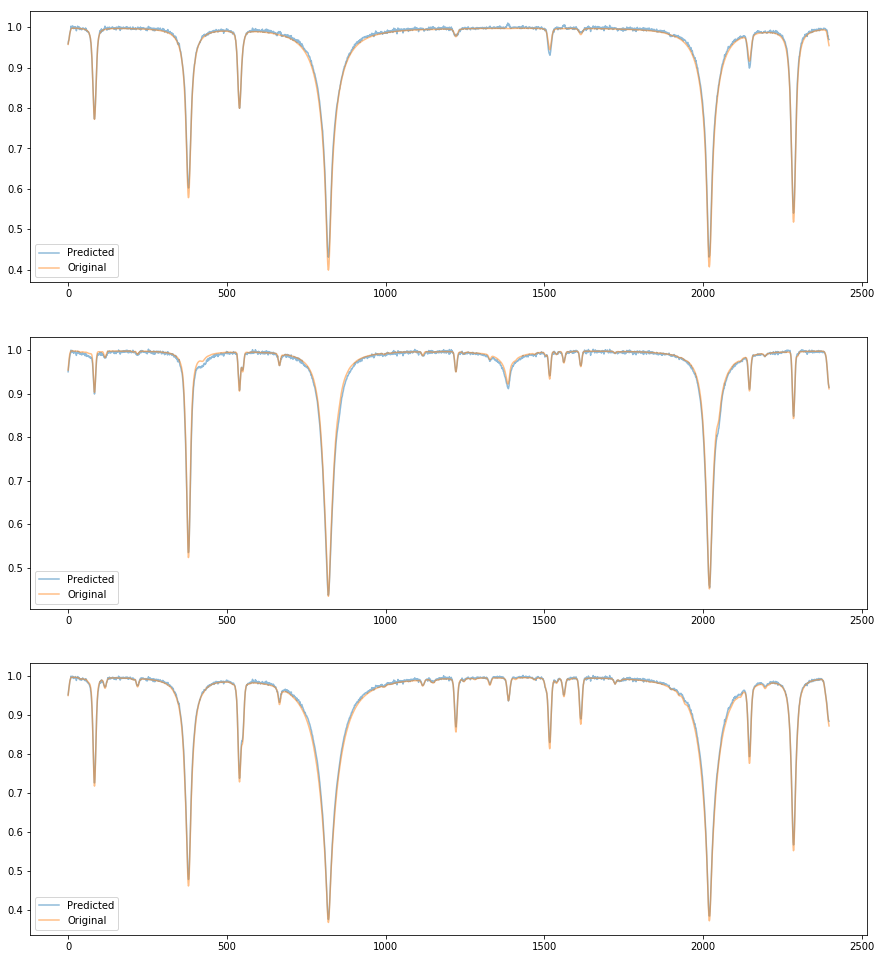

In [33]:
s = np.random.randint(low=0, high=len(X_std_test), size=3)
start = time.perf_counter()
pred_spectra = model.predict(X_std_test[s])
print("Processing time: {} seconds".format(time.perf_counter()-start))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,17))
ax[0].plot(pred_spectra[0], alpha=0.5, label="Predicted")
ax[1].plot(pred_spectra[1], alpha=0.5, label="Predicted")
ax[2].plot(pred_spectra[2], alpha=0.5, label="Predicted")
ax[0].plot(y_test[s[0]], alpha=0.5, label="Original")
ax[1].plot(y_test[s[1]], alpha=0.5, label="Original")
ax[2].plot(y_test[s[2]], alpha=0.5, label="Original")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


## Babysitting the Learning Rate

We talked about the importance of a good learning rate already – we don't want it to be too high, lest the cost function dance around the optimum value and diverge. We also don't want it to be too low because that means convergence will take a very long time.

<img src="https://dl.dropboxusercontent.com/s/9mmpydd5wvval65/learning_rates.png?dl=0" width="500">




Babysitting the learning rate can be tough because both higher and lower learning rates have their advantages. 

The great news is that we don't have to commit to one learning rate! With [learning rate scheduler](https://keras.io/api/callbacks/learning_rate_scheduler/) we can start with higher rates to move faster through gradient slopes, and slow it down when we reach a gradient valley in the hyper-parameter space which requires taking smaller steps.


In [41]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# model.fit(X_std_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(X_std_test, y_test), callbacks=[lr_scheduler])


There are many ways to schedule learning rates including decreasing the learning rate exponentially, or by using a step function, or tweaking it when the performance starts dropping, or using 1cycle scheduling.

In this kernel, I show you how to use the [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
 callback. This callback monitors if no improvement is seen for a **patience** number of epochs. When this happens, the learning rate is reduced of a **factor**.



In [42]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)



One could also add an [earling stopping callback](https://keras.io/api/callbacks/early_stopping/). 

In [43]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)



In [55]:
model_sc = model
model_sc.fit(X_std_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(X_std_test, y_test), callbacks=[early_stopping_cb,lr_scheduler])



Epoch 1/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.1447 - val_loss: 0.0660
Epoch 2/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0374
Epoch 3/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0210
Epoch 4/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 5/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 6/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 7/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0143
Epoch 8/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0119 - val_loss: 0.0128
Epoch 9/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 10/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.009

Epoch 72/1000
125/125 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 73/1000
125/125 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 74/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 75/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 76/1000
116/125 [==========================>...] - ETA: 0s - loss: 0.0015
Epoch 00076: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 77/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 78/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 79/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 80/1000
125/125 [======

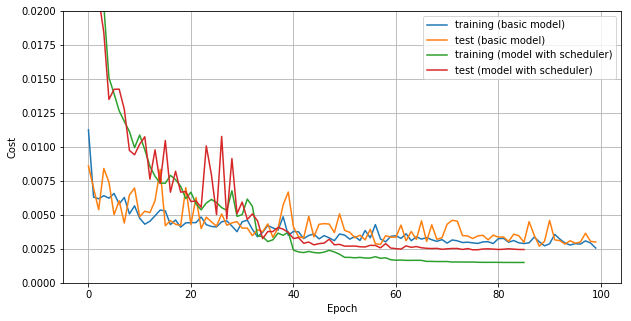

In [56]:
m2_tr_cost = model_sc.history.history['loss']
m2_val_cost = model_sc.history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(m1_tr_cost, label='training (basic model)')
ax.plot(m1_val_cost, label='test (basic model)')
ax.plot(m2_tr_cost, label='training (model with scheduler)')
ax.plot(m2_val_cost, label='test (model with scheduler)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
#ax.set_xlim([0,100])
ax.set_ylim([0,0.02])
ax.legend()
ax.grid()
plt.show()

## Vanishing gradients

Not all neural network layers learn at the same speed. So when the backprop algorithm propagates the error gradient from the output layer to the first layers, the gradients get smaller and smaller until they're almost negligible when they reach the first layers. This means the weights of the first layers aren't updated significantly at each step.

There are a couple of factors one should consider when this happens:

- the choice of the activation function

- the weight initialization

In [57]:
model.layers

These are the outputs from the neurons from the first hidden layer for the first instance
[0.07430821 0.         0.10310011 0.44414264 0.         0.32327688
 0.5229529  0.1942345  0.04507759 0.31748995 0.567309   0.15562192
 1.4979368  0.46586218 0.         0.99695075 0.         0.
 0.         0.24246354 0.         0.6591433  0.         0.
 0.19437172 0.         0.50091827 0.         0.         0.01881617
 0.4048096  0.6780855  0.50988567 0.05746283 0.         0.34387103
 0.         0.29724398 0.         0.         0.3919569  0.
 0.18809004 0.         0.6563481  0.         0.44514164 0.2037527
 0.9640656  0.23820005 0.         0.         0.         0.2767509
 0.2730791  0.         0.16699547 0.         0.4856028  0.23539574
 0.40967837 0.3311736  0.75543976 0.314256   0.         0.
 0.3160278  0.6631024  0.         0.0242139  0.14862138 0.
 0.         0.3441003  0.         0.5086826  0.3904396  0.
 0.2290258  0.04672532 0.19014658 0.         0.         0.09405947
 0.70390016 0.        

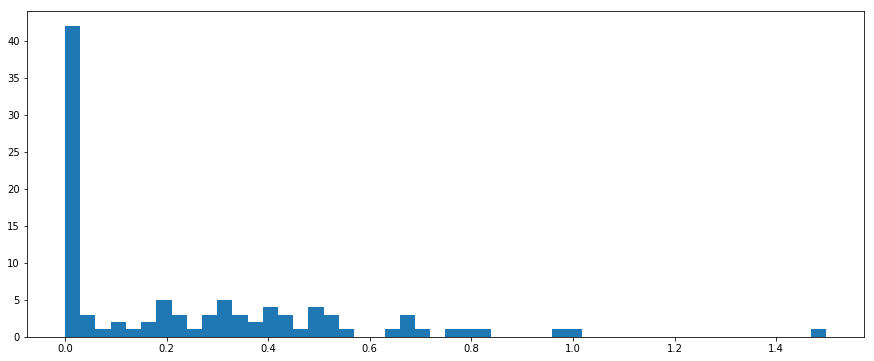

In [58]:
# the keras.backend.function calculates the outputs of a given layer

outputs_hidden_layers = keras.backend.function(
[model_sc.layers[0].input],  # we will feed the function with the input of the first layer
[model_sc.layers[2].output] # we want to get the output of the first hidden layer
)

print("These are the outputs from the neurons from the first hidden layer for the first instance")
neurons_relu = outputs_hidden_layers([X_std_test])[0][0]
print(neurons_relu)

plt.figure(figsize=(15,6))
h=plt.hist(neurons_relu, bins=50)

In [59]:
# layer 1
L1 = keras.layers.Dense(100)(input_layer)
L1a = tf.keras.layers.LeakyReLU(alpha=0.2)(L1)

# layer 2
L2 = keras.layers.Dense(100)(L1a)
L2a = tf.keras.layers.LeakyReLU(alpha=0.2)(L2)

# layer 3
L3 = keras.layers.Dense(100)(L2a)
L3a = tf.keras.layers.LeakyReLU(alpha=0.2)(L3)

# layer 4
L4 = keras.layers.Dense(100)(L3a)
L4a = tf.keras.layers.LeakyReLU(alpha=0.2)(L4)

# layer 5
L5 = keras.layers.Dense(100)(L4a)
L5a = tf.keras.layers.LeakyReLU(alpha=0.2)(L5)

shape_y = y_train.shape[1]

#  output
output = keras.layers.Dense(shape_y)(L5a)

model_LR = keras.models.Model(inputs=[input_layer], outputs=[output])

optimizer = keras.optimizers.Adam(learning_rate=0.002, epsilon=1e-07, beta_1=0.9, beta_2=0.999) #adam
model_LR.compile(loss=[loss], optimizer=optimizer)

model_LR.fit(X_std_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_std_test, y_test), callbacks=[early_stopping_cb,lr_scheduler])


Epoch 1/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1547 - val_loss: 0.0696
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0427
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0230
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0159
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0201
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.0107
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 9/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0168
Epoch 10/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0114 - val_lo

These are the outputs from the neurons from the first hidden layer and for the first instance
[ 8.5954905e-02 -1.5048294e-01 -1.3938335e-01 -4.4980925e-02
 -1.6677968e-01  2.2474112e-01  3.9433211e-01  7.6477420e-01
  9.1274053e-01 -1.3506494e-01  2.2687533e-01 -9.1791980e-02
  2.6560150e-02 -6.3366740e-04 -1.0443272e-01  4.7722518e-01
  1.1933879e-01 -4.8698824e-02  1.2929434e-01  3.3736885e-02
  2.9065746e-01 -2.1279275e-01  2.8161511e-01 -1.8373791e-02
 -3.0759716e-02 -6.9568649e-02  9.9520022e-01  2.3622590e-01
 -3.2152687e-03  1.6642772e-02  2.7196172e-01  2.4910730e-01
 -1.1024078e-01  1.1658691e+00  4.6965754e-01 -5.9285142e-02
 -1.8258629e-02  1.1007751e+00  9.6109271e-02  8.8355029e-01
 -1.9726751e-02 -1.4800008e-01  7.7022123e-01  4.0488258e-01
 -5.4497130e-02  3.6958855e-01 -2.5111232e-02  8.2262725e-01
  4.9878347e-01  4.5777160e-01  2.5500688e-01  4.6564844e-01
  2.5306028e-01 -2.9889351e-02  1.3148509e-02 -6.0844716e-02
  1.0042277e-01  6.5718687e-01 -4.9637258e-02  9.997

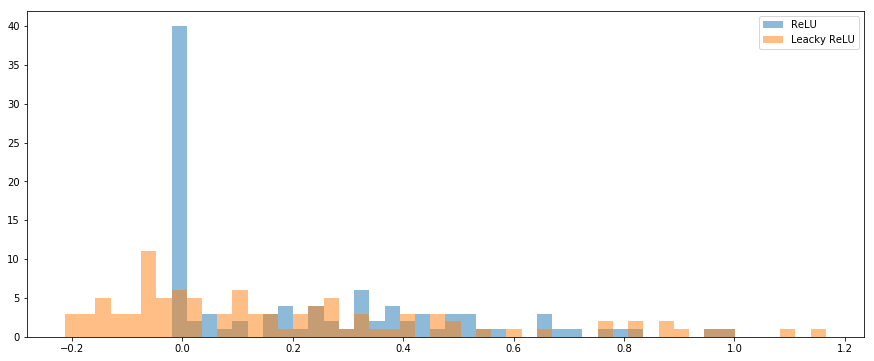

In [60]:
outputs_hidden_layers = keras.backend.function(
[model_LR.layers[0].input],  # we will feed the function with the input of the first layer
[model_LR.layers[2].output,] # we want to get the output of the first hidden layer
)

print("These are the outputs from the neurons from the first hidden layer and for the first instance")
neurons_leaky_relu = outputs_hidden_layers([X_std_test])[0][0]
print(neurons_leaky_relu)

plt.figure(figsize=(15,6))
a = plt.hist(neurons_relu, bins=50, range=[min(neurons_leaky_relu),max(neurons_leaky_relu)], alpha=0.5, label='ReLU')
a = plt.hist(neurons_leaky_relu, bins=50, range=[min(neurons_leaky_relu),max(neurons_leaky_relu)], alpha=0.5, label='Leacky ReLU')
plt.legend()


### Vanishing gradient and the weight initialization


- When using ReLU or leaky RELU, use [He initialization](https://arxiv.org/pdf/1502.01852.pdf)
- When using SELU or ELU, use [LeCun initialization](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
- When using softmax, logistic, or tanh, use [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

Keras uses Gorot as default.


In [70]:
# layer 1
L1 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(input_layer)
L1a = tf.keras.layers.LeakyReLU(alpha=0.2)(L1)

# layer 2
L2 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(L1a)
L2a = tf.keras.layers.LeakyReLU(alpha=0.2)(L2)

# layer 3
L3 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(L2a)
L3a = tf.keras.layers.LeakyReLU(alpha=0.2)(L3)

# layer 4
L4 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(L3a)
L4a = tf.keras.layers.LeakyReLU(alpha=0.2)(L4)

# layer 5
L5 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(L4a)
L5a = tf.keras.layers.LeakyReLU(alpha=0.2)(L5)

shape_y = y_train.shape[1]

#  output
output = keras.layers.Dense(shape_y)(L5a)

model_ini = keras.models.Model(inputs=[input_layer], outputs=[output])

optimizer = keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-07, beta_1=0.9, beta_2=0.999) #adam
model_ini.compile(loss=[loss], optimizer=optimizer)

model_ini.fit(X_std_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_std_test, y_test), callbacks=[early_stopping_cb,lr_scheduler])


Epoch 1/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1729 - val_loss: 0.0956
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0836 - val_loss: 0.0765
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.0609
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0487
Epoch 5/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0410 - val_loss: 0.0419
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0344
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0259
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0213
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0223
Epoch 10/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0180 - val_lo

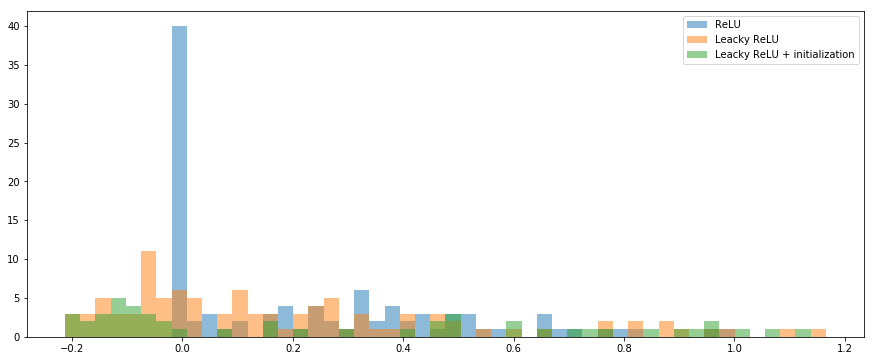

In [73]:
outputs_hidden_layers = keras.backend.function(
[model_ini.layers[0].input],  # we will feed the function with the input of the first layer
[model_ini.layers[2].output,] # we want to get the output of the second layer
)

neurons_leacky_relu_init = outputs_hidden_layers([X_std_test])[0][0]

plt.figure(figsize=(15,6))
a = plt.hist(neurons_relu, bins=50, range=[min(neurons_leaky_relu),max(neurons_leaky_relu)], alpha=0.5, label='ReLU')
a = plt.hist(neurons_leaky_relu, bins=50, range=[min(neurons_leaky_relu),max(neurons_leaky_relu)], alpha=0.5, label='Leacky ReLU')
a = plt.hist(neurons_leacky_relu_init, bins=50, range=[min(neurons_leaky_relu),max(neurons_leaky_relu)], alpha=0.5, label='Leacky ReLU + initialization')
plt.legend()



## Dropout



In [75]:
# layer 1
L1 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(input_layer)
L1d = tf.keras.layers.Dropout(0.3)(L1)
L1a = tf.keras.layers.LeakyReLU(alpha=0.2)(L1d)

# layer 2
L2 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L1a)
L2d = tf.keras.layers.Dropout(0.3)(L2)
L2a = tf.keras.layers.LeakyReLU(alpha=0.2)(L2d)

# layer 3
L3 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L2a)
L3d = tf.keras.layers.Dropout(0.3)(L3)
L3a = tf.keras.layers.LeakyReLU(alpha=0.2)(L3d)

# layer 4
L4 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L3a)
L4d = tf.keras.layers.Dropout(0.3)(L4)
L4a = tf.keras.layers.LeakyReLU(alpha=0.2)(L4d)

# layer 5
L5 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L4a)
L5d = tf.keras.layers.Dropout(0.3)(L5)
L5a = tf.keras.layers.LeakyReLU(alpha=0.2)(L5d)

shape_y = y_train.shape[1]

#  output
output = keras.layers.Dense(shape_y)(L5a)

model_do = keras.models.Model(inputs=[input_layer], outputs=[output])
optimizer = keras.optimizers.Adam(lr=0.002) #adam
model_do.compile(loss=[loss], optimizer=optimizer)
model_do.fit(X_std_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(X_std_test, y_test), callbacks=[early_stopping_cb,lr_scheduler])



Epoch 1/1000
125/125 [==============================] - 1s 8ms/step - loss: 0.2430 - val_loss: 0.1959
Epoch 2/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1310 - val_loss: 0.1577
Epoch 3/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.0901 - val_loss: 0.0741
Epoch 4/1000
125/125 [==============================] - 1s 8ms/step - loss: 0.0655 - val_loss: 0.0434
Epoch 5/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.0485 - val_loss: 0.0326
Epoch 6/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.0432 - val_loss: 0.0184
Epoch 7/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.0384 - val_loss: 0.0248
Epoch 8/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.0359 - val_loss: 0.0315
Epoch 9/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.0353 - val_loss: 0.0197
Epoch 10/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.032

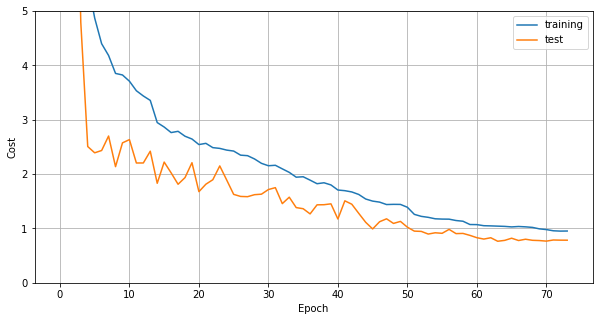

In [106]:
m5_tr_cost = model_do.history.history['loss']
m5_val_cost = model_do.history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(m5_tr_cost, label='training')
ax.plot(m5_val_cost, label='test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
#ax.set_xlim([0,100])
ax.set_ylim([0,5])
ax.legend()
ax.grid()
plt.show()

Since dropout is only active during training, the training loss is penalized compared to the test loss. So comparing the two can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training).

MAPE test: 0.7642591595649719
MAPE train: 0.8013380765914917


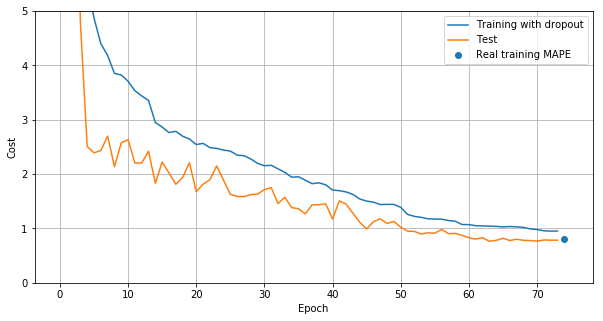

In [110]:
mape = tf.keras.losses.MeanAbsolutePercentageError()

pred_spectra_test = model_do.predict(X_std_test)
print("MAPE test: {}".format(mape(y_test, pred_spectra_test).numpy()))

pred_spectra_train = model_do.predict(X_std_train)
print("MAPE train: {}".format(mape(y_train, pred_spectra_train).numpy()))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(m5_tr_cost, label='Training with dropout')
ax.plot(m5_val_cost, label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
pred_spectra = model_do.predict(X_std_test)
ax.scatter(len(m5_tr_cost),mape(y_train, pred_spectra_train).numpy(), label='Real training MAPE')
#ax.scatter(len(tr_cost),mape(y_test, pred_spectra_test).numpy())
#ax.set_xlim([0,100])
ax.set_ylim([0,5])
ax.legend()
ax.grid()
plt.show()

Processing time: 0.06273895801859908 seconds


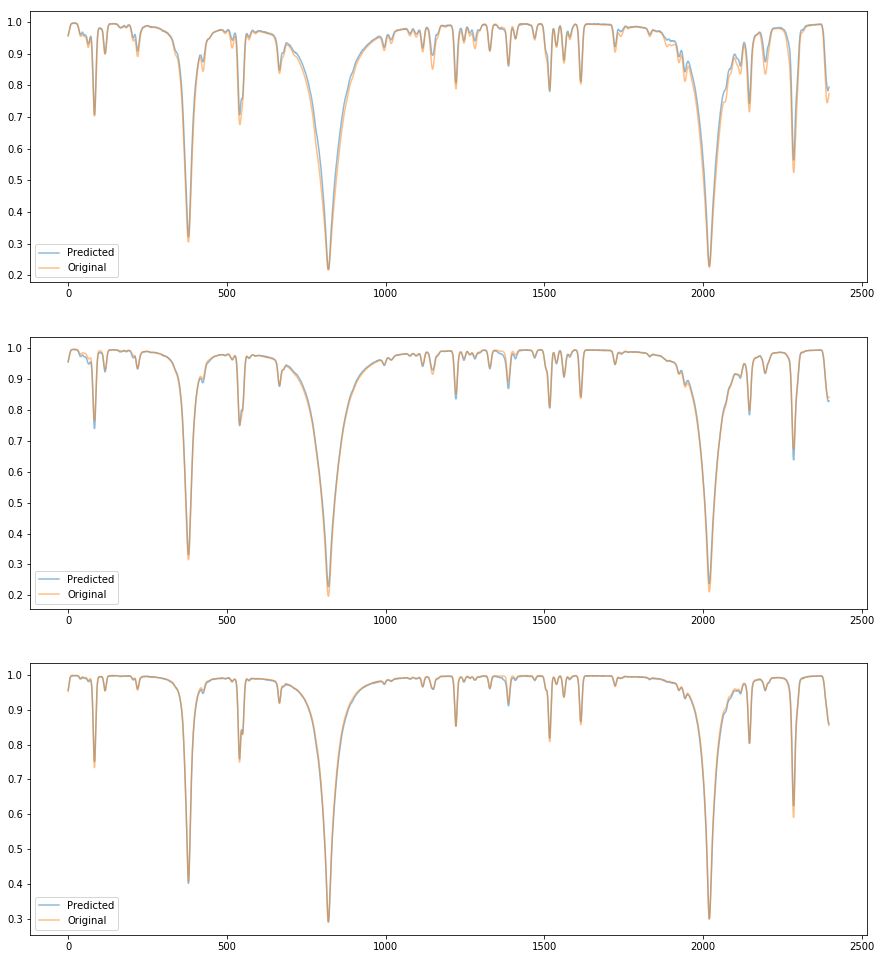

In [112]:
s = np.random.randint(low=0, high=len(X_std_test), size=3)
start = time.perf_counter()

pred_spectra = model_do.predict(X_std_test[s])
print("Processing time: {} seconds".format(time.perf_counter()-start))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,17))
ax[0].plot(pred_spectra[0], alpha=0.5, label="Predicted")
ax[1].plot(pred_spectra[1], alpha=0.5, label="Predicted")
ax[2].plot(pred_spectra[2], alpha=0.5, label="Predicted")
ax[0].plot(y_test[s[0]], alpha=0.5, label="Original")
ax[1].plot(y_test[s[1]], alpha=0.5, label="Original")
ax[2].plot(y_test[s[2]], alpha=0.5, label="Original")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


### A more "complex" architecture

<img src="https://dl.dropboxusercontent.com/s/1eyrwi448wv7rsf/concat_ANN.png?dl=0" width="600">



In [126]:
columns = ['teff', 'logg', 'feH', 'vmic', 'vbroad', 'sife', 'cafe', 'tife',
       'mgfe', 'ndfe', 'sfe', 'zrfe', 'nfe', 'crfe', 'cefe', 'nife']


shape_X_main_par = X_std_train[:,0:5].shape[1] # 'teff', 'logg', 'feH', 'vmic', 'vbroad'
shape_X_abundances = X_std_train[:,5:].shape[1] # 'sife', 'cafe', 'tife', 'mgfe', 'ndfe', 'sfe', 'zrfe', 'nfe', 'crfe', 'cefe', 'nife'

#  inputs
input_layer_X_main_par = keras.layers.Input(shape=[shape_X_main_par])
input_layer_X_abundances = keras.layers.Input(shape=[shape_X_abundances])

# layer 1
L1 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(input_layer_X_main_par)
L1d = tf.keras.layers.Dropout(0.3)(L1)
L1a = tf.keras.layers.LeakyReLU(alpha=0.2)(L1d)

# layer 2
L2 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L1a)
L2d = tf.keras.layers.Dropout(0.3)(L2)
L2a = tf.keras.layers.LeakyReLU(alpha=0.2)(L2d)

# add the input abundances to the third layer
L2_merged = keras.layers.concatenate([L2a, input_layer_X_abundances])

# layer 3
L3 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L2_merged)
L3d = tf.keras.layers.Dropout(0.3)(L3)
L3a = tf.keras.layers.LeakyReLU(alpha=0.2)(L3d)

# layer 4
L4 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L3a)
L4d = tf.keras.layers.Dropout(0.3)(L4)
L4a = tf.keras.layers.LeakyReLU(alpha=0.2)(L4d)

# layer 5
L5 = keras.layers.Dense(300,kernel_initializer = 'he_normal')(L4a)
L5d = tf.keras.layers.Dropout(0.3)(L5)
L5a = tf.keras.layers.LeakyReLU(alpha=0.2)(L5d)

shape_y = y_train.shape[1]

#  output
output = keras.layers.Dense(shape_y)(L5a)

model_cx = keras.models.Model(inputs=[input_layer_X_main_par, input_layer_X_abundances], outputs=[output])
optimizer = keras.optimizers.Adam(lr=0.002) #adam
model_cx.compile(loss=[loss], optimizer=optimizer)

new_train = [X_std_train[:,0:5],X_std_train[:,5:]]
new_test = [X_std_test[:,0:5],X_std_test[:,5:]]
model_cx.fit(new_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(new_test, y_test), callbacks=[early_stopping_cb,lr_scheduler])



Epoch 1/1000
125/125 [==============================] - 1s 7ms/step - loss: 28.8382 - val_loss: 24.0856
Epoch 2/1000
125/125 [==============================] - 1s 6ms/step - loss: 14.4419 - val_loss: 11.1746
Epoch 3/1000
125/125 [==============================] - 1s 6ms/step - loss: 7.6550 - val_loss: 3.1984
Epoch 4/1000
125/125 [==============================] - 1s 8ms/step - loss: 5.5310 - val_loss: 5.5196
Epoch 5/1000
125/125 [==============================] - 1s 6ms/step - loss: 5.1241 - val_loss: 2.4892
Epoch 6/1000
125/125 [==============================] - 1s 8ms/step - loss: 4.5989 - val_loss: 2.2258
Epoch 7/1000
125/125 [==============================] - 1s 7ms/step - loss: 4.2931 - val_loss: 3.0418
Epoch 8/1000
125/125 [==============================] - 1s 8ms/step - loss: 4.1366 - val_loss: 3.5775
Epoch 9/1000
125/125 [==============================] - 1s 7ms/step - loss: 4.0448 - val_loss: 3.5357
Epoch 10/1000
125/125 [==============================] - 1s 8ms/step - loss: 3

Epoch 75/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.8138 - val_loss: 0.5707
Epoch 76/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7965 - val_loss: 0.5746
Epoch 77/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7907 - val_loss: 0.6027
Epoch 78/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7963 - val_loss: 0.6000
Epoch 79/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7859 - val_loss: 0.6088
Epoch 80/1000
118/125 [===========================>..] - ETA: 0s - loss: 0.7843
Epoch 00080: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
125/125 [==============================] - 1s 6ms/step - loss: 0.7847 - val_loss: 0.5782
Epoch 81/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7685 - val_loss: 0.5836
Epoch 82/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.7620 - val_loss: 0.6062
Epoch 83/1000
125/125 [========

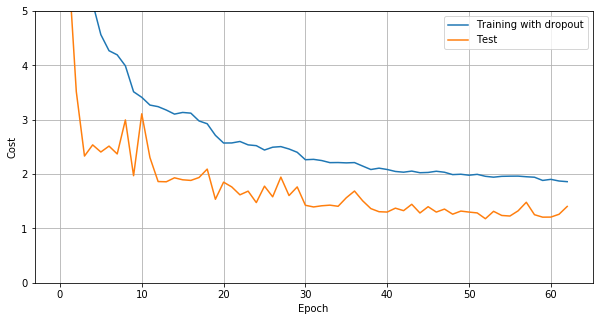

In [125]:
m6_tr_cost = model_cx.history.history['loss']
m6_val_cost = model_cx.history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(m6_tr_cost, label='Training with dropout')
ax.plot(m6_val_cost, label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
ax.set_ylim([0,5])
ax.legend()
ax.grid()
plt.show()